In [5]:
!pip install --upgrade pip scipy numba matplotlib pandas > /dev/null
!pip install prometheus-api-client uuid mlflow keras tensorflow > /dev/null
!pip install tensorflow==1.14 > /dev/null
print("Done")

Done


In [0]:
from prometheus_api_client import Metric, MetricsList, PrometheusConnect
from prometheus_api_client.utils import parse_datetime, parse_timedelta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

1
<class 'prometheus_api_client.metric.Metric'>
request_duration_seconds_count {'app': 'jupyterhub', 'code': '200', 'deployment': 'jupyterhub-7', 'deploymentconfig': 'jupyterhub', 'handler': 'jupyterhub.handlers.metrics.MetricsHandler', 'instance': '10.128.5.199:8080', 'job': 'kubernetes-pods', 'kubernetes_namespace': 'data-science-on-the-moc-openshift', 'kubernetes_pod_name': 'jupyterhub-7-hd8d9', 'method': 'GET'} 



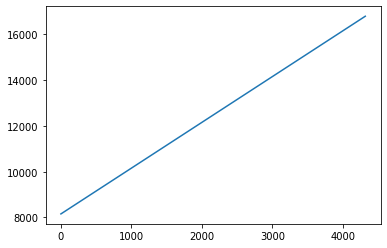

In [133]:
link1 = "https://prometheus-data-science-on-the-moc-openshift.k-apps.osh.massopen.cloud"
link = "http://prometheus-lts-data-science-on-the-moc-openshift.k-apps.osh.massopen.cloud"
pc = PrometheusConnect(url=link, disable_ssl=True)

start_time = parse_datetime("3d")
end_time = parse_datetime("now")
chunk_size = parse_timedelta("now", "1d")


metric1 = 'request_duration_seconds_count{app="jupyterhub",code="200",deployment="jupyterhub-7",deploymentconfig="jupyterhub",handler="jupyterhub.handlers.metrics.MetricsHandler",instance="10.128.5.199:8080",job="kubernetes-pods",kubernetes_namespace="data-science-on-the-moc-openshift",kubernetes_pod_name="jupyterhub-7-hd8d9",method="GET"}'
metric2 = 'scrape_duration_seconds{app="jupyterhub",deployment="jupyterhub-7",deploymentconfig="jupyterhub",instance="10.128.5.199:8080",job="kubernetes-pods",kubernetes_namespace="data-science-on-the-moc-openshift",kubernetes_pod_name="jupyterhub-7-hd8d9"}'

metric_data = pc.get_metric_range_data(
    metric1,
    start_time=start_time,
    end_time=end_time,
    chunk_size=chunk_size,
)

metrics_object_list = MetricsList(metric_data)
print(len(metrics_object_list))
for item in metrics_object_list:
    print(type(item))
    
for item in metrics_object_list:
    print(item.metric_name, item.label_config, "\n")
    
my_metric_object = metrics_object_list[0] # one of the metrics from the list

my_metric_object.metric_values['y'].plot()

In [0]:
# Important Functions and Imports
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler

def process_data(number_of_features, train_test_split_ratio, df):
  np_arr = df.values
  scaler = MinMaxScaler(feature_range = (0, 1))
  scaled_np_arr = scaler.fit_transform(np_arr[:,1].reshape(-1, 1))
  np_arr[:,1] = scaled_np_arr.flatten()

  train = np_arr[:int(np_arr.shape[0]*train_test_split_ratio),:]
  test = np_arr[int(np_arr.shape[0]*train_test_split_ratio):,:]

  train_x = np.array(train[:,1])[np.newaxis, :].T
  test_x = np.array(test[:,1])[np.newaxis, :].T
  for i in range(number_of_features):
    train_x = np.concatenate((train_x, np.roll(train[:,1],-i)[np.newaxis,:].T), axis=1)
    test_x = np.concatenate((test_x, np.roll(test[:,1],-i)[np.newaxis,:].T), axis=1)

  train_x = train_x[:train_x.shape[0]-number_of_features,:number_of_features]
  test_x = test_x[:test_x.shape[0]-number_of_features,:number_of_features]

  train_y = np.roll(train[:,1],-number_of_features)
  train_y = train_y[:train_y.shape[0]-number_of_features]

  test_y = np.roll(test[:,1],-number_of_features)
  test_y = test_y[:test_y.shape[0]-number_of_features]
  train_x = train_x.reshape(train_x.shape[0],1,train_x.shape[1])
  test_x = test_x.reshape(test_x.shape[0],1,test_x.shape[1])
  
  return (train_x, train_y, test_x, test_y, scaler)

class Specs:
  def __init__(self, DenseCount = 0, LSTMCount = 0, epochs = 0, loss = np.inf):
    self.DenseCount = DenseCount
    self.LSTMCount = LSTMCount
    self.loss = loss
    self.epochs = epochs

  def __str__(self):
    return str(self.LSTMCount) + " " + str(self.DenseCount) + " " + str(self.epochs)  + " " + str(self.loss)
 
def trainLSTM(specs, final = False):
  model = Sequential()
  model.add(LSTM(64, return_sequences = True, input_shape=(1,number_of_features)))
  model.add(LSTM(specs.LSTMCount))
  model.add(Dense(specs.DenseCount))
  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='adam')
  if final:
    history = model.fit(train_x, train_y, epochs = specs.epochs, batch_size = 512, verbose = 2)
  else:
    history = model.fit(train_x, train_y, epochs = specs.epochs, batch_size = 512, verbose = 0, validation_split=0.2)
  
  return (model, history)

def loss_curve(history, final = False):
  train_loss = history.history['loss']
  if not final:
    val_loss = history.history['val_loss']

  x_axis = range(1, len(history.history['loss'])+1)
  
  plt.figure()
  plt.plot(x_axis, train_loss, label="Training Loss")
  
  if not final:
    plt.plot(x_axis, val_loss, label="Validation Loss")

  plt.ylabel('Loss Value')
  plt.xlabel('Epochs')
  plt.title('Epochs vs Loss')
  plt.legend()
  
  if not final:
    print('Minimum Validation Loss is:' + str(min(val_loss)))
    print('Epoch: ' + str(val_loss.index(min(val_loss)) + 1))

In [135]:
number_of_features = 10
(train_x, train_y, test_x, test_y, scaler) = process_data(number_of_features, 0.8, my_metric_object.metric_values)

# Tuning Hyperparameters
bestSpecs = Specs()
for i in range(5, 8):
  LSTMCount = 2**i
  for j in range(5, 8):
    DenseCount = 2**j

    newSpecs = Specs(DenseCount, LSTMCount, 50)

    model, history = trainLSTM(newSpecs)
    val_loss = history.history['val_loss']
    loss = min(val_loss)
    
    if (loss < bestSpecs.loss):
      bestSpecs = newSpecs
      bestSpecs.loss = loss
      bestSpecs.epochs = val_loss.index(min(val_loss)) + 1
      print("New Results:", bestSpecs)

New Results: 32 32 50 0.00011795177023209956
New Results: 32 64 50 2.249104007310909e-05
New Results: 32 128 50 5.4938533278049285e-06
New Results: 64 128 8 1.945860487361695e-06


Now training on 64 128 50 1.945860487361695e-06
Epoch 1/50
 - 9s - loss: 0.1525
Epoch 2/50
 - 0s - loss: 0.0419
Epoch 3/50
 - 0s - loss: 0.0263
Epoch 4/50
 - 0s - loss: 0.0172
Epoch 5/50
 - 0s - loss: 0.0142
Epoch 6/50
 - 0s - loss: 0.0085
Epoch 7/50
 - 0s - loss: 0.0055
Epoch 8/50
 - 0s - loss: 0.0024
Epoch 9/50
 - 0s - loss: 0.0011
Epoch 10/50
 - 0s - loss: 4.1669e-04
Epoch 11/50
 - 0s - loss: 2.1442e-04
Epoch 12/50
 - 0s - loss: 2.0871e-04
Epoch 13/50
 - 0s - loss: 2.0844e-04
Epoch 14/50
 - 0s - loss: 1.8139e-04
Epoch 15/50
 - 0s - loss: 1.5426e-04
Epoch 16/50
 - 0s - loss: 1.3758e-04
Epoch 17/50
 - 0s - loss: 1.2914e-04
Epoch 18/50
 - 0s - loss: 1.2191e-04
Epoch 19/50
 - 0s - loss: 1.1467e-04
Epoch 20/50
 - 0s - loss: 1.0742e-04
Epoch 21/50
 - 0s - loss: 1.0045e-04
Epoch 22/50
 - 0s - loss: 9.3912e-05
Epoch 23/50
 - 0s - loss: 8.7655e-05
Epoch 24/50
 - 0s - loss: 8.1599e-05
Epoch 25/50
 - 0s - loss: 7.5797e-05
Epoch 26/50
 - 0s - loss: 7.0392e-05
Epoch 27/50
 - 0s - loss: 6.5079e-0

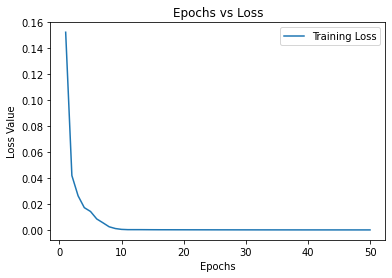

In [143]:
# Train final model
finalModelFlag = True
bestSpecs.epochs = 50
print("Now training on", bestSpecs)
finalmodel, history = trainLSTM(bestSpecs, finalModelFlag)
loss_curve(history, finalModelFlag)

Results


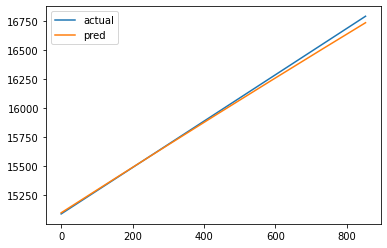

621.5296928374495


In [144]:
# Evaluate Test Predictions
pred_t = finalmodel.predict(test_x)
pred_t_inverse = scaler.inverse_transform(pred_t)
test_y_inverse = scaler.inverse_transform(test_y.reshape(-1, 1))

print("Results")
plt.figure()
plt.plot(test_y_inverse, label = 'actual')
# plt.legend()
# plt.figure()
plt.plot(pred_t_inverse, label = 'pred')
plt.legend()
plt.show()

print(mse(pred_t_inverse, test_y_inverse))